## Model Development

## Loading in Data

In [14]:
%cd /Users/cyrusnavasca9/Documents/Github/datathon/med_proj/data
import matplotlib.pyplot as plt
import numpy as np
from data.data_loader import DataLoader
import pandas as pd

/Users/cyrusnavasca9/Documents/Github/datathon/med_proj/data


/Users/cyrusnavasca9/Documents/Github/datathon/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [15]:
%cd /Users/cyrusnavasca9/Documents/Github/datathon
data_loader = DataLoader()
zip_paths = ["ed2015-sas.sas7bdat.zip", "ed2016_sas.zip", "ed2017_sas.zip", "ed2018_sas.zip",
                "ed2019_sas.zip", "ed2020_sas.zip", "ed2021_sas.zip"]
df = pd.DataFrame()
for zip_path in zip_paths:
    df_temp = data_loader.load_data(zip_path)
    df = pd.concat([df, df_temp])

/Users/cyrusnavasca9/Documents/Github/datathon/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/cyrusnavasca9/Documents/Github/datathon
Reading SAS file: /Users/cyrusnavasca9/Documents/Github/datathon/med_proj/data/ed2015-sas.sas7bdat
Loaded shape: (21061, 1031)
Reading SAS file: /Users/cyrusnavasca9/Documents/Github/datathon/med_proj/data/ed2015-sas.sas7bdat
Loaded shape: (21061, 1031)
Reading SAS file: /Users/cyrusnavasca9/Documents/Github/datathon/med_proj/data/ed2015-sas.sas7bdat
Loaded shape: (21061, 1031)
Reading SAS file: /Users/cyrusnavasca9/Documents/Github/datathon/med_proj/data/ed2015-sas.sas7bdat
Loaded shape: (21061, 1031)
Reading SAS file: /Users/cyrusnavasca9/Documents/Github/datathon/med_proj/data/ed2015-sas.sas7bdat
Loaded shape: (21061, 1031)
Reading SAS file: /Users/cyrusnavasca9/Documents/Github/datathon/med_proj/data/ed2015-sas.sas7bdat
Loaded shape: (21061, 1031)
Reading SAS file: /Users/cyrusnavasca9/Documents/Github/datathon/med_proj/data/ed2015-sas.sas7bdat
Loaded shape: (21061, 1031)


## Data Exploration

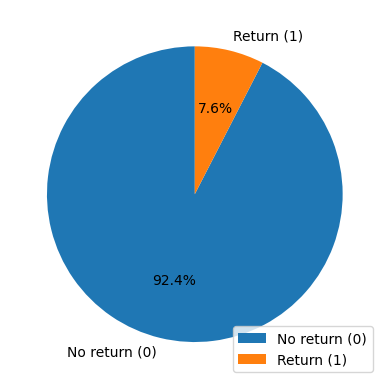

In [55]:
counts = df["RETRNED"].value_counts()
plt.pie(counts, labels=["No return (0)", "Return (1)"], autopct="%1.1f%%", startangle=90)
plt.legend()
plt.show()

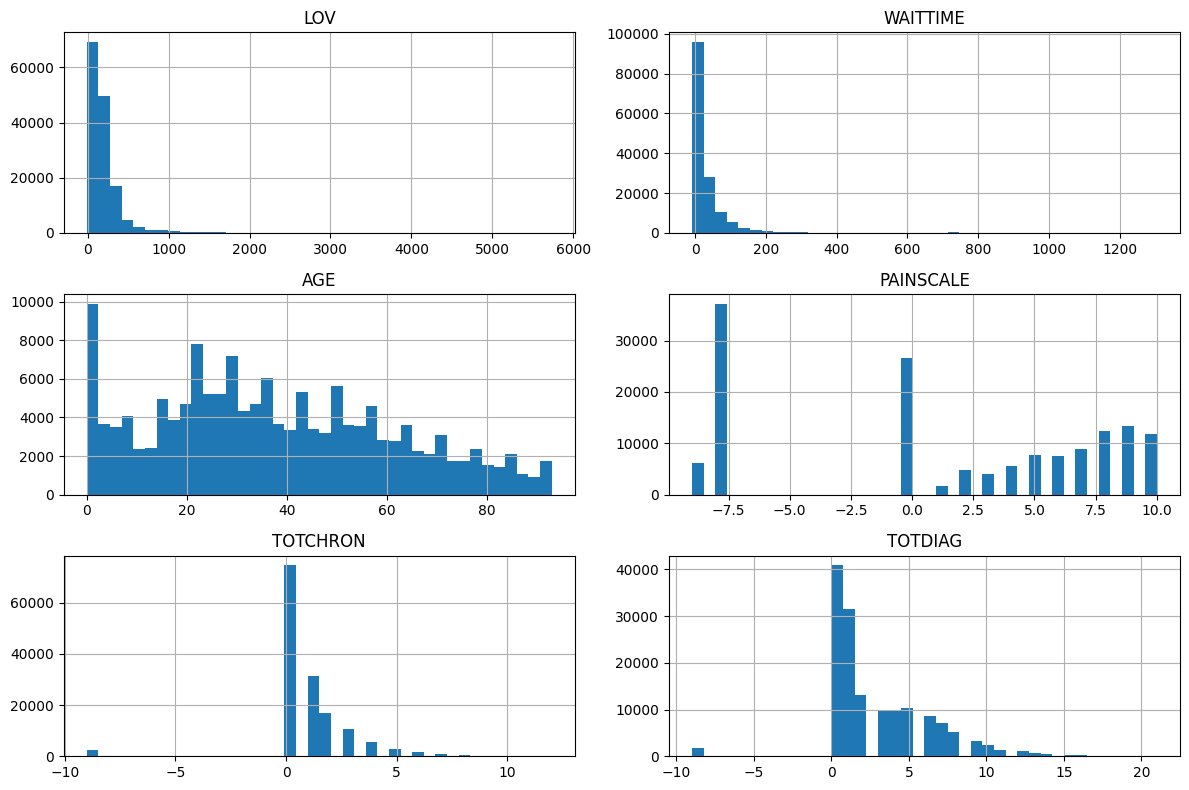

In [56]:
df[["LOV", "WAITTIME", "AGE", "PAINSCALE", "TOTCHRON", "TOTDIAG"]].hist(bins=40, figsize=(12, 8))
plt.tight_layout()
plt.show()

## Data Cleaning

In [57]:
df = df[(df["TOTPROC"] >= 0) & (df["TOTCHRON"] >= 0) & (df["TOTDIAG"] >= 0) & (df["PAINSCALE"] >= 0)]

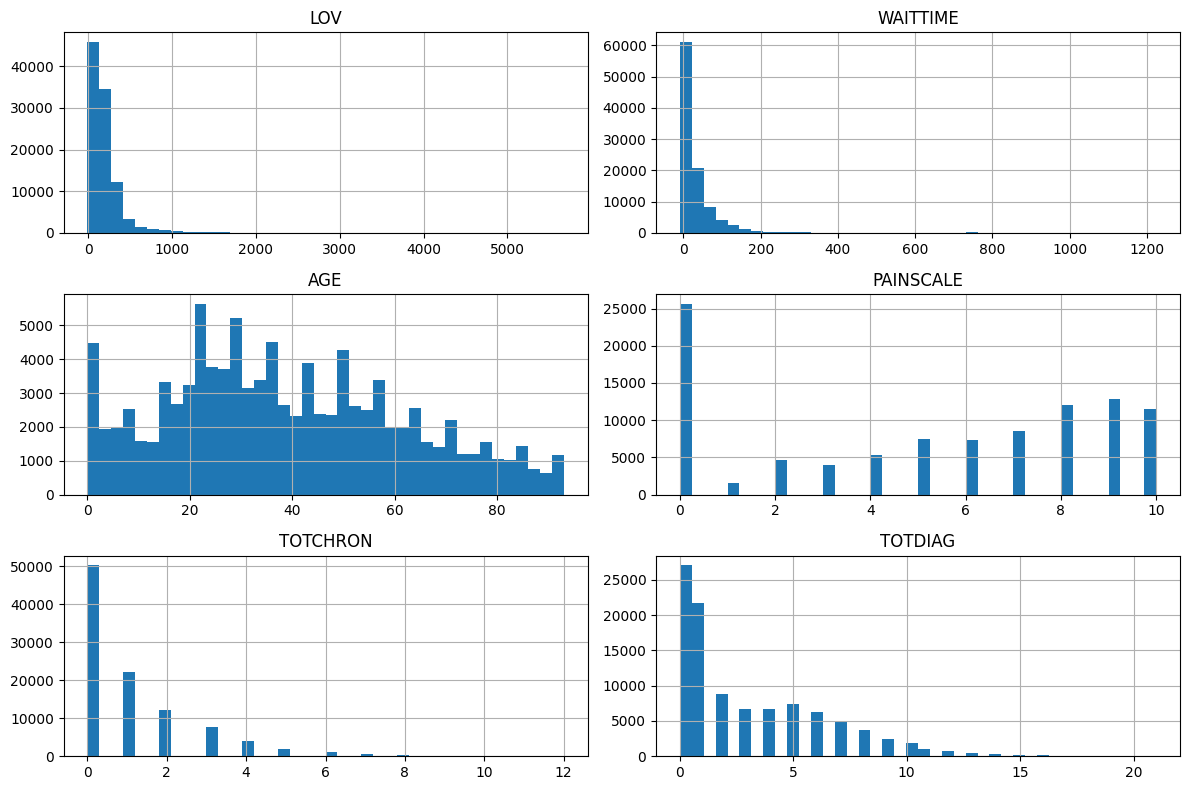

In [58]:
df[["LOV", "WAITTIME", "AGE", "PAINSCALE", "TOTCHRON", "TOTDIAG"]].hist(bins=40, figsize=(12, 8))
plt.tight_layout()
plt.show()

## Training/Testing Split

In [59]:
# Extracting selecting columns fron RFE
X = df[["LOV", "WAITTIME", "IMMEDR", "AGE", "PAINSCALE", "TOTCHRON", "TOTDIAG"]].copy()
y = df["RETRNED"]

In [60]:
mask = y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].astype(int).reset_index(drop=True)
X = X.dropna(axis=0)
y = y.loc[X.index].reset_index(drop=True)
X = X.reset_index(drop=True)

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  
    random_state=42,   
    stratify=y        
)

len(X_train), len(X_test)

(80656, 20165)

## Random Forest Model

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Model fitting
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'   # weights classes inversely to frequency
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, mean_squared_error

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train accuracy:", round(train_accuracy, 5))
print("Test accuracy:", round(test_accuracy, 5))
print("Train MSE:", round(train_mse, 5))
print("Test MSE:", round(test_mse, 5))

Train accuracy: 1.0
Test accuracy: 1.0
Train MSE: 0.0
Test MSE: 0.0


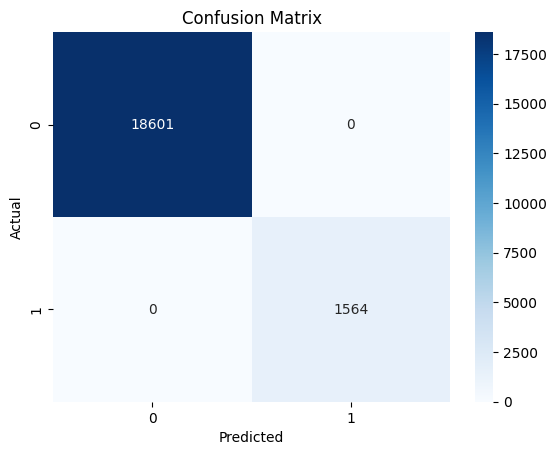

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## LightGBM Model

In [99]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

lgb = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.6,
    num_leaves=31,
    random_state=42,
    class_weight='balanced'
)

lgb.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', learning_rate=0.6, max_depth=6,
               n_estimators=200, random_state=42)

In [100]:
y_train_pred = lgb.predict(X_train)
y_test_pred = lgb.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train MSE:", round(train_mse, 4))
print("Test MSE:", round(test_mse, 4))
print("Train accuracy:", round(train_accuracy, 4))
print("Test accuracy:", round(test_accuracy, 4))

Train MSE: 0.0027
Test MSE: 0.0026
Train accuracy: 0.9973
Test accuracy: 0.9974


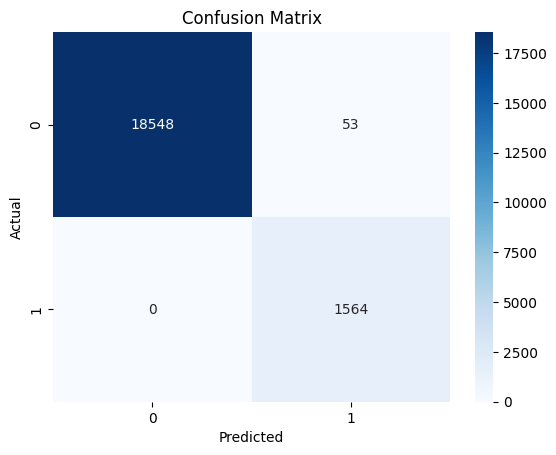

In [101]:
cm = confusion_matrix(y_test, y_test_pred)

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Logistic Regression Model

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [77]:
y_train_pred = logreg.predict(X_train_scaled)
y_test_pred = logreg.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train MSE:", round(train_mse, 4))
print("Test MSE:", round(test_mse, 4))
print("Train accuracy:", round(train_accuracy, 4))
print("Test accuracy:", round(test_accuracy, 4))

Train MSE: 0.4583
Test MSE: 0.4558
Train accuracy: 0.5417
Test accuracy: 0.5442


## Model Ensembling

In [83]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for OOF predictions
oof_logreg = np.zeros(len(X))
oof_rf = np.zeros(len(X))
oof_lgb = np.zeros(len(X))

for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train = y.iloc[train_idx]

    # Clone models so we don't overwrite originals
    logreg_clone = clone(logreg)
    rf_clone = clone(rf)
    lgb_clone = clone(lgb)

    logreg_clone.fit(X_train, y_train)
    rf_clone.fit(X_train, y_train)
    lgb_clone.fit(X_train, y_train)

    # Store positive-class probabilities
    oof_logreg[val_idx] = logreg_clone.predict_proba(X_val)[:, 1]
    oof_rf[val_idx] = rf_clone.predict_proba(X_val)[:, 1]
    oof_lgb[val_idx] = lgb_clone.predict_proba(X_val)[:, 1]

In [86]:
meta_X = np.column_stack([oof_logreg, oof_rf, oof_lgb])

meta_model = LogisticRegression()
meta_model.fit(meta_X, y)

logreg.fit(X, y)
rf.fit(X, y)
lgb.fit(X, y)

test_logreg = logreg.predict_proba(X_test)[:, 1]
test_rf     = rf.predict_proba(X_test)[:, 1]
test_lgb    = lgb.predict_proba(X_test)[:, 1]

meta_test_X = np.column_stack([test_logreg, test_rf, test_lgb])

final_proba = meta_model.predict_proba(meta_test_X)[:, 1] 
final_pred  = (final_proba > 0.5).astype(int)         

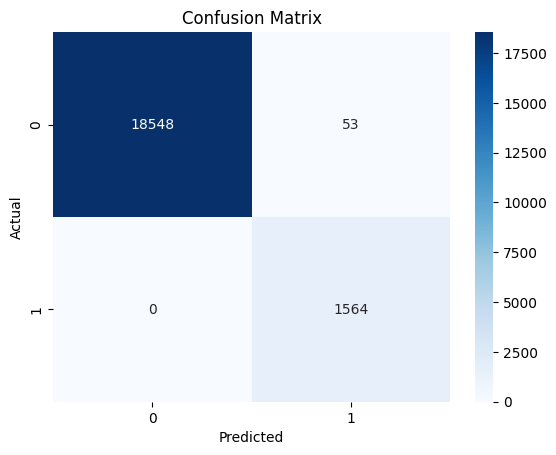

In [ ]:
cm = confusion_matrix(y_test, final_pred)

cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Generating Model Artifact

In [90]:
import json
from datetime import datetime

# Optional: compute final metrics if not already in variables
# test_accuracy = accuracy_score(y_test, final_pred)
# test_mse = mean_squared_error(y_test, final_pred)

artifact = {
    "model_version": "1.0",
    "created_at": datetime.now().isoformat(),
    "task": "classification",
    "target": "RETRNED",
    "feature_names": list(X.columns),
    "preprocessing": {
        "scaler": "StandardScaler",
        "used_for": "logistic_regression_only",
    },
    "base_models": [
        {"name": "RandomForestClassifier", "params": rf.get_params()},
        {"name": "LGBMClassifier", "params": lgb.get_params()},
        {"name": "LogisticRegression", "params": logreg.get_params()},
    ],
    "meta_model": {"name": "LogisticRegression", "params": meta_model.get_params()},
    "metrics": {
        "train_accuracy": float(train_accuracy) if 'train_accuracy' in dir() else None,
        "test_accuracy": float(test_accuracy) if 'test_accuracy' in dir() else None,
        "train_mse": float(train_mse) if 'train_mse' in dir() else None,
        "test_mse": float(test_mse) if 'test_mse' in dir() else None,
    },
}

# Convert any non-JSON-serializable types (e.g. numpy types)
def to_serializable(obj):
    if hasattr(obj, 'item'):
        return obj.item()
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

with open("med_proj/model_artifact.json", "w") as f:
    json.dump(artifact, f, indent=2, default=to_serializable)